<a href="https://colab.research.google.com/github/JayYongjaeKim/MoLab/blob/FirstTon/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score

# 데이터 로드
main = pd.read_csv("./train_users_2.csv/train_users_2.csv")
log = pd.read_csv("./sessions.csv/sessions.csv")

import datetime
main['date_first_booking'] = pd.to_datetime(main['date_first_booking'])
main['date_account_created'] = pd.to_datetime(main['date_account_created'])
main['timestamp_first_active'] = pd.to_datetime(main['timestamp_first_active'], format='%Y%m%d%H%M%S')
main['timestamp_first_active'] = main['timestamp_first_active'].dt.date

main['is_booked'] = main['date_first_booking'].notnull().astype(int)

main = main[(main['age'] >= 11) & (main['age'] <= 69)]

main = main[(main['gender'] != '-unknown-') & (main['gender'] != 'OTHER')]

main['timedelta'] = (main['date_first_booking'] - pd.to_datetime(main['timestamp_first_active'])).dt.days

main = main.drop(columns=['date_first_booking'])

main['timedelta'] = main['timedelta'].fillna(0)

main = main.drop(columns=['first_affiliate_tracked'], axis=0)

log['action'] = log['action'].fillna('unknown')
log['action_detail'] = log['action_detail'].fillna('unknown')
log['action_type'] = log['action_type'].fillna('unknown')

encoded_data = pd.get_dummies(log[['action', 'action_detail', 'action_type']])

action_pivot = log.pivot_table(index='user_id', columns='action', values='secs_elapsed', aggfunc='count').fillna(0)
action_detail_pivot = log.pivot_table(index='user_id', columns='action_detail', values='secs_elapsed', aggfunc='count').fillna(0)
action_type_pivot = log.pivot_table(index='user_id', columns='action_type', values='secs_elapsed', aggfunc='count').fillna(0)

from functools import reduce
pivot_tables = [action_pivot, action_detail_pivot, action_type_pivot]

log_pivot = reduce(lambda left, right: pd.merge(left, right, on='user_id', how='outer'), pivot_tables).fillna(0)
log_pivot.reset_index(inplace=True)

fast_group = main[main['timedelta'] <= 0]['id']
slow_group = main[main['timedelta'] > 0]['id']

fast_actions = log[log['user_id'].isin(fast_group)]['action_detail'].value_counts().head(20).index
slow_actions = log[log['user_id'].isin(slow_group)]['action_detail'].value_counts().head(20).index

anti_join_features = list(set(fast_actions) - set(slow_actions)) + list(set(slow_actions) - set(fast_actions))

log['median_time'] = log.groupby(['action_detail'])['secs_elapsed'].transform('median')

log['weight'] = log['median_time'] / log.groupby('action_detail')['secs_elapsed'].transform('count')
log['score'] = log['secs_elapsed'] * log['weight']

scores = log.groupby('user_id')['score'].sum().reset_index(name='total_score')

In [ ]:
anti_join_features

['login', 'change_contact_host_dates']

In [ ]:
from sklearn.preprocessing import StandardScaler

log_pivot2 = log_pivot.drop(columns=['user_id'], errors='ignore')

scaler = StandardScaler()
log_pivot_scaled = scaler.fit_transform(log_pivot2)

from sklearn.decomposition import PCA
pca = PCA(n_components=7)
pca_features = pca.fit_transform(log_pivot2)

explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = explained_variance.cumsum()

print("Explained Variance Ratio:", explained_variance)
print("Cumulative Explained Variance:", cumulative_explained_variance)

for i in range(7):
    log_pivot[f'PC{i+1}'] = pca_features[:, i]

# PCA 결과와 main 데이터 결합
merged_data = pd.merge(main, log_pivot, left_on='id', right_on='user_id', how='left').fillna(0)
merged_data = pd.merge(merged_data, scores, left_on='id', right_on='user_id', how='left').fillna(0)

merged_data['date_account_created'] = pd.to_datetime(merged_data['date_account_created'])
merged_data['timestamp_first_active'] = pd.to_datetime(merged_data['timestamp_first_active'])
merged_data['days_since_creation'] = (merged_data['date_account_created'] - merged_data['date_account_created'].min()).dt.days
merged_data['days_since_first_active'] = (merged_data['timestamp_first_active'] - merged_data['timestamp_first_active'].min()).dt.days


merged_data = merged_data.drop(columns=['date_account_created', 'timestamp_first_active'], errors='ignore')
# Feature와 Target 설정

purchased_data = merged_data[merged_data['is_booked'] == 1]
# X = merged_data[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'total_score', 'days_since_creation', 'days_since_first_active']]
# y_timedelta = merged_data['timedelta']

Explained Variance Ratio: [0.56168115 0.1264302  0.077033   0.071427   0.03939402 0.02250662
 0.01782001]
Cumulative Explained Variance: [0.56168115 0.68811135 0.76514435 0.83657135 0.87596537 0.89847199
 0.91629201]


In [ ]:
main

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,signup_app,first_device_type,first_browser,country_destination,is_booked,timedelta
1,820tgsjxq7,2011-05-25,2009-05-23,MALE,38.0,facebook,0,en,seo,google,Web,Mac Desktop,Chrome,NDF,0,0.0
2,4ft3gnwmtx,2010-09-28,2009-06-09,FEMALE,56.0,basic,3,en,direct,direct,Web,Windows Desktop,IE,US,1,419.0
3,bjjt8pjhuk,2011-12-05,2009-10-31,FEMALE,42.0,facebook,0,en,direct,direct,Web,Mac Desktop,Firefox,other,1,1043.0
6,lsw9q7uk0j,2010-01-02,2010-01-02,FEMALE,46.0,basic,0,en,other,craigslist,Web,Mac Desktop,Safari,US,1,3.0
7,0d01nltbrs,2010-01-03,2010-01-03,FEMALE,47.0,basic,0,en,direct,direct,Web,Mac Desktop,Safari,US,1,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213440,04y8115avm,2014-06-30,2014-06-30,FEMALE,24.0,basic,25,en,direct,direct,iOS,iPhone,Mobile Safari,NDF,0,0.0
213441,omlc9iku7t,2014-06-30,2014-06-30,FEMALE,34.0,basic,0,en,direct,direct,Web,Mac Desktop,Chrome,ES,1,44.0
213443,0k26r3mir0,2014-06-30,2014-06-30,FEMALE,36.0,basic,0,en,sem-brand,google,Web,Mac Desktop,Safari,US,1,13.0
213445,qbxza0xojf,2014-06-30,2014-06-30,FEMALE,23.0,basic,0,en,sem-brand,google,Web,Windows Desktop,IE,US,1,2.0


In [ ]:
log_pivot

,user_id,10,11,12,15,about_us,accept_decline,account,acculynk_bin_check_failed,acculynk_bin_check_success,...,submit,unknown,view_y,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,00023iyk9l,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,21.0,-22.530799,-3.513156,-9.433390,-0.914228,3.286120,2.373031,-1.444273
1,0010k6l0om,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,15.0,17.0,-5.972345,9.629552,-7.098939,7.221195,4.052951,7.093888,2.237529
2,001wyh0pz8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,5.0,8.0,6.368138,56.156715,47.778985,-61.246702,12.751732,0.278442,-24.117020
3,0028jgx1x1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,15.0,-21.508003,-5.635428,-1.044647,-14.465136,4.156766,4.564128,-0.884870
4,002qnbzfs5,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,15.0,76.0,216.0,415.270245,-62.367943,226.768721,12.526471,-52.307151,-2.591556,3.683691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135478,zzxox7jnrx,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,17.0,23.0,-2.986708,17.452551,8.051020,10.336348,2.370257,0.722755,7.980943
135479,zzy7t0y9cm,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,-44.569482,-0.915204,-4.116609,-2.256223,-0.510048,3.956002,-1.006621
135480,zzysuoqg6x,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-47.352853,-2.722425,-2.274559,-2.723202,1.107126,3.705174,0.161175
135481,zzywmcn0jv,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,8.0,9.0,-18.866570,4.143403,-8.422468,3.636508,-4.249745,8.625406,-9.885082


In [ ]:
purchased_data = merged_data

### 여기부터 분류 코드

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# 듀레이션 그룹 Y값 파생
purchased_data['duration_group'] = purchased_data['timedelta'].apply(lambda x: 0 if x == 0 else 1)

In [ ]:
# 학습에 필요없는 컬럼제거
purchased_data.drop(columns=['id','timedelta','is_booked','user_id_y','user_id_x'],inplace=True)

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
def label_encode_dataframe(df):
    """
    데이터프레임의 범주형 열 전체에 라벨 인코딩을 적용하는 함수.
    """
    label_encoders = {}  # 각 열의 LabelEncoder 객체를 저장
    for col in df.select_dtypes(include=['object', 'category']).columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))  # 라벨 인코딩 적용
        label_encoders[col] = le  # 각 열의 LabelEncoder 저장
    return df, label_encoders

In [ ]:
df_encoded, encoders = label_encode_dataframe(purchased_data)

In [ ]:
df_encoded

,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,signup_app,first_device_type,first_browser,...,PC2,PC3,PC4,PC5,PC6,PC7,total_score,days_since_creation,days_since_first_active,duration_group
0,1,38.0,1,0,5,7,7,2,3,7,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,508,0,0
1,0,56.0,0,3,5,2,3,2,6,14,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,269,17,1
2,0,42.0,1,0,5,2,3,2,3,13,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,702,161,1
3,0,46.0,0,0,5,3,2,2,3,30,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0,224,1
4,0,47.0,0,0,5,2,3,2,3,30,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1,225,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105230,0,24.0,0,25,5,2,3,3,8,21,...,-18.471425,-3.817582,-14.376660,-8.935698,-5.701053,1.762552,1.964032e+03,1640,1864,0
105231,0,34.0,0,0,5,2,3,2,3,7,...,5.987227,-2.648921,-1.891523,3.339671,2.750173,3.192057,5.462724e+04,1640,1864,1
105232,0,36.0,0,0,5,5,7,2,3,30,...,21.827471,-12.563809,12.296228,11.260069,-8.196711,5.855254,1.230323e+05,1640,1864,1
105233,0,23.0,0,0,5,5,7,2,6,14,...,24.642176,-1.923029,7.428735,-7.187100,2.523524,8.817255,9.006198e+03,1640,1864,1


In [ ]:
X = df_encoded.drop(columns=['duration_group'])
y = df_encoded['duration_group']

In [ ]:
# LightGBM의 파이썬 패키지인 lightgbm에서 LGBMClassifier 임포트
from lightgbm import LGBMClassifier

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=156 )

from imblearn.over_sampling import SMOTE

# SMOTE를 사용한 오버샘플링
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 위에서 만든 X_train, y_train을 다시 쪼개서 90%는 학습과 10%는 검증용 데이터로 분리
X_tr, X_val, y_tr, y_val= train_test_split(X_train_resampled, y_train_resampled, test_size=0.1, random_state=156 )

# 앞서 XGBoost와 동일하게 n_estimators는 400 설정.
lgbm_wrapper = LGBMClassifier(n_estimators=400, learning_rate=0.05)

# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능.
evals = [(X_tr, y_tr), (X_val, y_val)]
lgbm_wrapper.fit(X_tr, y_tr, early_stopping_rounds=100, eval_metric="logloss", eval_set=evals, verbose=True)
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:, 1]

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	training's binary_logloss: 0.658233	valid_1's binary_logloss: 0.658545
[2]	training's binary_logloss: 0.626576	valid_1's binary_logloss: 0.627208
[3]	training's binary_logloss: 0.597879	valid_1's binary_logloss: 0.598816
[4]	training's binary_logloss: 0.571738	valid_1's binary_logloss: 0.57296
[5]	training's binary_logloss: 0.547818	valid_1's binary_logloss: 0.549314
[6]	training's binary_logloss: 0.525926	valid_1's binary_logloss: 0.527653
[7]	training's binary_logloss: 0.505815	valid_1's binary_logloss: 0.507829
[8]	training's binary_logloss: 0.48728	valid_1's binary_logloss: 0.489552
[9]	training's binary_logloss: 0.470224	valid_1's binary_logloss: 0.472711
[10]	training's binary_logloss: 0.454421	valid_1's binary_logloss: 0.457149
[11]	training's binary_logloss: 0.439837	valid_1's binary_logloss: 0.442784
[12]	training's binary_logloss: 0.426346	valid_1's binary_logloss: 0.429484
[13]	training's binary_logloss: 0.413798	valid_1's binary_logloss: 0.417167
[14]	training's binary_

[118]	training's binary_logloss: 0.222728	valid_1's binary_logloss: 0.238576
[119]	training's binary_logloss: 0.222595	valid_1's binary_logloss: 0.238542
[120]	training's binary_logloss: 0.222428	valid_1's binary_logloss: 0.238434
[121]	training's binary_logloss: 0.222267	valid_1's binary_logloss: 0.238351
[122]	training's binary_logloss: 0.222092	valid_1's binary_logloss: 0.238218
[123]	training's binary_logloss: 0.221871	valid_1's binary_logloss: 0.238102
[124]	training's binary_logloss: 0.221726	valid_1's binary_logloss: 0.238014
[125]	training's binary_logloss: 0.221542	valid_1's binary_logloss: 0.237822
[126]	training's binary_logloss: 0.221409	valid_1's binary_logloss: 0.237738
[127]	training's binary_logloss: 0.221286	valid_1's binary_logloss: 0.237703
[128]	training's binary_logloss: 0.221137	valid_1's binary_logloss: 0.237598
[129]	training's binary_logloss: 0.220914	valid_1's binary_logloss: 0.237495
[130]	training's binary_logloss: 0.2207	valid_1's binary_logloss: 0.237299
[

[230]	training's binary_logloss: 0.208108	valid_1's binary_logloss: 0.231666
[231]	training's binary_logloss: 0.208016	valid_1's binary_logloss: 0.231669
[232]	training's binary_logloss: 0.207952	valid_1's binary_logloss: 0.231621
[233]	training's binary_logloss: 0.207844	valid_1's binary_logloss: 0.231537
[234]	training's binary_logloss: 0.207745	valid_1's binary_logloss: 0.231506
[235]	training's binary_logloss: 0.207689	valid_1's binary_logloss: 0.231517
[236]	training's binary_logloss: 0.207628	valid_1's binary_logloss: 0.231549
[237]	training's binary_logloss: 0.207482	valid_1's binary_logloss: 0.231401
[238]	training's binary_logloss: 0.207417	valid_1's binary_logloss: 0.231354
[239]	training's binary_logloss: 0.207353	valid_1's binary_logloss: 0.231345
[240]	training's binary_logloss: 0.207295	valid_1's binary_logloss: 0.231361
[241]	training's binary_logloss: 0.207225	valid_1's binary_logloss: 0.231366
[242]	training's binary_logloss: 0.207106	valid_1's binary_logloss: 0.231313

[368]	training's binary_logloss: 0.196937	valid_1's binary_logloss: 0.228733
[369]	training's binary_logloss: 0.196866	valid_1's binary_logloss: 0.228759
[370]	training's binary_logloss: 0.196797	valid_1's binary_logloss: 0.228747
[371]	training's binary_logloss: 0.196745	valid_1's binary_logloss: 0.228751
[372]	training's binary_logloss: 0.196664	valid_1's binary_logloss: 0.228745
[373]	training's binary_logloss: 0.196585	valid_1's binary_logloss: 0.228734
[374]	training's binary_logloss: 0.196482	valid_1's binary_logloss: 0.228635
[375]	training's binary_logloss: 0.196416	valid_1's binary_logloss: 0.228628
[376]	training's binary_logloss: 0.196368	valid_1's binary_logloss: 0.228635
[377]	training's binary_logloss: 0.196302	valid_1's binary_logloss: 0.228632
[378]	training's binary_logloss: 0.196255	valid_1's binary_logloss: 0.22861
[379]	training's binary_logloss: 0.196216	valid_1's binary_logloss: 0.228621
[380]	training's binary_logloss: 0.196132	valid_1's binary_logloss: 0.228642


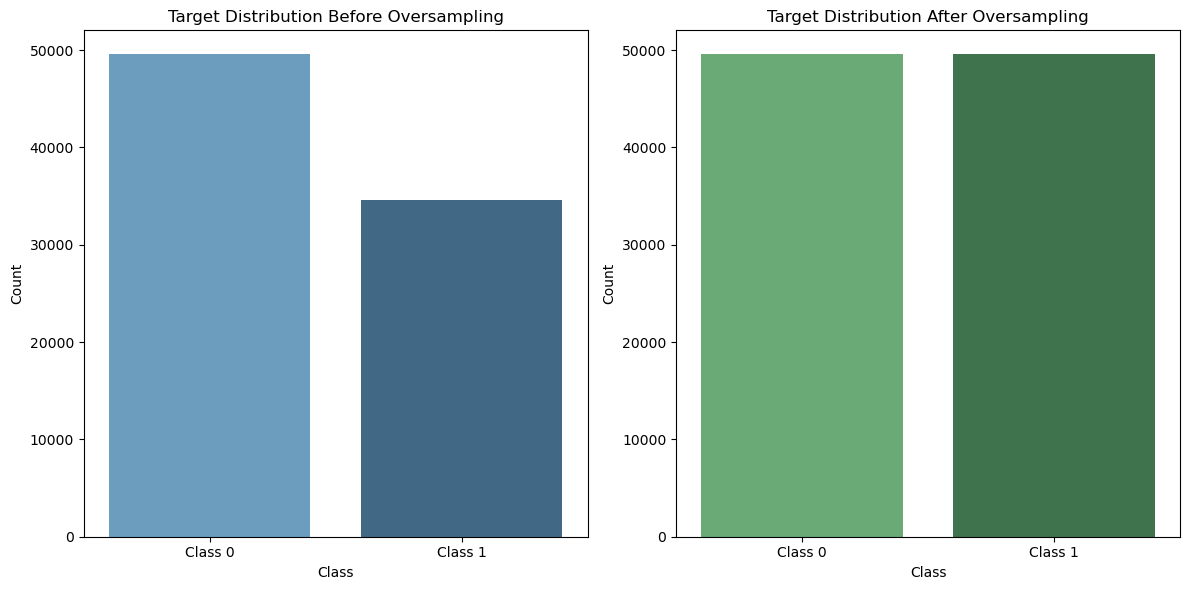

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 오버샘플링 이전 타겟 데이터 분포 계산
before_counts = y_train.value_counts()

# 오버샘플링 이후 타겟 데이터 분포 계산
after_counts = pd.Series(y_train_resampled).value_counts()

# 시각화
plt.figure(figsize=(12, 6))

# 1. 오버샘플링 이전 데이터 분포
plt.subplot(1, 2, 1)
sns.barplot(x=before_counts.index, y=before_counts.values, palette='Blues_d')
plt.title('Target Distribution Before Oversampling')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(ticks=before_counts.index, labels=[f'Class {c}' for c in before_counts.index])

# 2. 오버샘플링 이후 데이터 분포
plt.subplot(1, 2, 2)
sns.barplot(x=after_counts.index, y=after_counts.values, palette='Greens_d')
plt.title('Target Distribution After Oversampling')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(ticks=after_counts.index, labels=[f'Class {c}' for c in after_counts.index])

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, 	recall, f1, roc_auc))

get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[10637  1820]
 [  222  8368]]
정확도: 0.9030, 정밀도: 0.8214, 재현율: 0.9742,    F1: 0.8913, AUC:0.9477


In [ ]:
# 랜덤 포레스트 학습 및 별도의 테스트 셋으로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train_resampled, y_train_resampled)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test , pred)
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy))

랜덤 포레스트 정확도: 0.8781


In [ ]:
pred_proba = rf_clf.predict_proba(X_test)[:, 1]

In [ ]:
get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[10836  1621]
 [  945  7645]]
정확도: 0.8781, 정밀도: 0.8251, 재현율: 0.8900,    F1: 0.8563, AUC:0.9253


In [ ]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
evals = [(X_test, y_test)]
xgb_wrapper.fit(X_train_resampled, y_train_resampled, early_stopping_rounds=100, eval_metric="logloss",
                eval_set=evals, verbose=True)

ws100_preds = xgb_wrapper.predict(X_test)
ws100_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

C:\Users\82104\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\82104\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.62594
[1]	validation_0-logloss:0.57117
[2]	validation_0-logloss:0.52585
[3]	validation_0-logloss:0.48796
[4]	validation_0-logloss:0.45597
[5]	validation_0-logloss:0.42882
[6]	validation_0-logloss:0.40562
[7]	validation_0-logloss:0.38574
[8]	validation_0-logloss:0.36879
[9]	validation_0-logloss:0.35399
[10]	validation_0-logloss:0.34118
[11]	validation_0-logloss:0.33021
[12]	validation_0-logloss:0.32052
[13]	validation_0-logloss:0.31207
[14]	validation_0-logloss:0.30484
[15]	validation_0-logloss:0.29834
[16]	validation_0-logloss:0.29264
[17]	validation_0-logloss:0.28776
[18]	validation_0-logloss:0.28335
[19]	validation_0-logloss:0.27944
[20]	validation_0-logloss:0.27608
[21]	validation_0-logloss:0.27300
[22]	validation_0-logloss:0.27043
[23]	validation_0-logloss:0.26793
[24]	validation_0-logloss:0.26581
[25]	validation_0-logloss:0.26398
[26]	validation_0-logloss:0.26223
[27]	validation_0-logloss:0.26064
[28]	validation_0-logloss:0.25934
[29]	validation_0-loglos

[238]	validation_0-logloss:0.23957
[239]	validation_0-logloss:0.23945
[240]	validation_0-logloss:0.23944
[241]	validation_0-logloss:0.23944
[242]	validation_0-logloss:0.23945
[243]	validation_0-logloss:0.23944
[244]	validation_0-logloss:0.23944
[245]	validation_0-logloss:0.23944
[246]	validation_0-logloss:0.23944
[247]	validation_0-logloss:0.23944
[248]	validation_0-logloss:0.23944
[249]	validation_0-logloss:0.23943
[250]	validation_0-logloss:0.23942
[251]	validation_0-logloss:0.23940
[252]	validation_0-logloss:0.23942
[253]	validation_0-logloss:0.23941
[254]	validation_0-logloss:0.23937
[255]	validation_0-logloss:0.23937
[256]	validation_0-logloss:0.23938
[257]	validation_0-logloss:0.23929
[258]	validation_0-logloss:0.23930
[259]	validation_0-logloss:0.23931
[260]	validation_0-logloss:0.23931
[261]	validation_0-logloss:0.23932
[262]	validation_0-logloss:0.23934
[263]	validation_0-logloss:0.23934
[264]	validation_0-logloss:0.23934
[265]	validation_0-logloss:0.23935
[266]	validation_0-l

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

get_clf_eval(y_test, ws100_preds, ws100_pred_proba)

오차 행렬
[[10647  1810]
 [  242  8348]]
정확도: 0.9025, 정밀도: 0.8218, 재현율: 0.9718,    F1: 0.8905, AUC:0.9476


오차 행렬:
[[10647  1810]
 [  242  8348]]
정확도: 0.9025, 정밀도: 0.8218, 재현율: 0.9718, F1: 0.8905, AUC: 0.9476


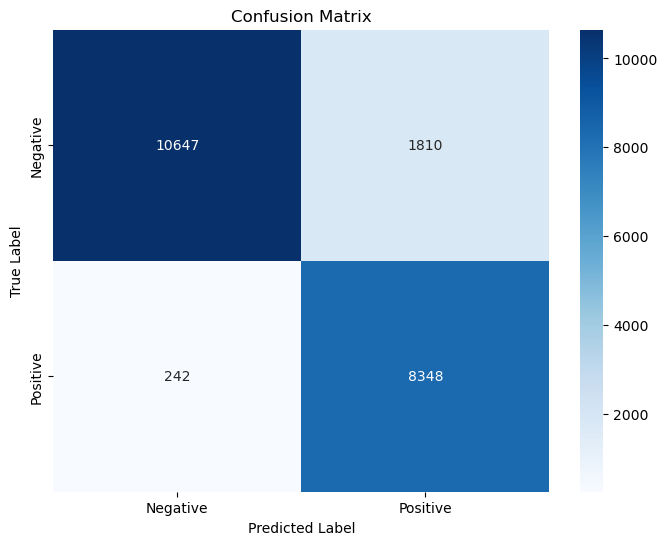

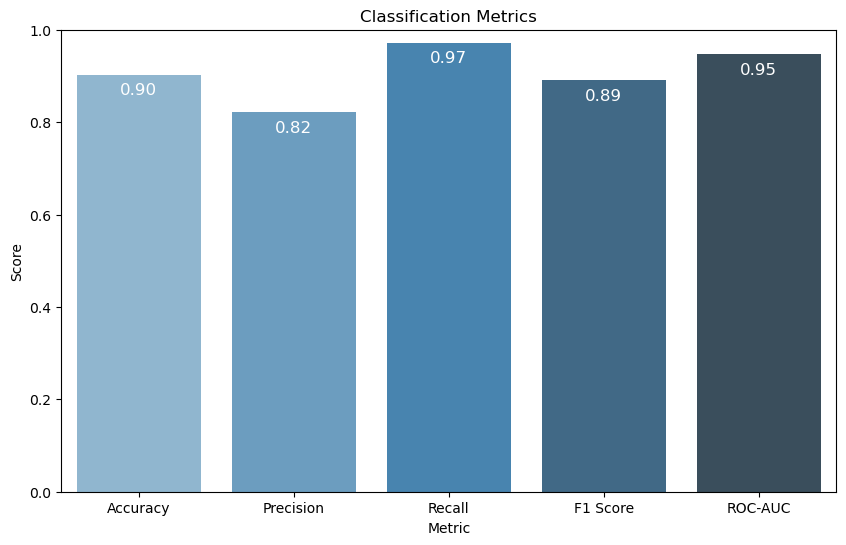

In [ ]:
visualize_clf_eval_with_values(y_test, ws100_preds, ws100_pred_proba)

오차 행렬:
[[10637  1820]
 [  222  8368]]
정확도: 0.9030, 정밀도: 0.8214, 재현율: 0.9742, F1: 0.8913, AUC: 0.9253


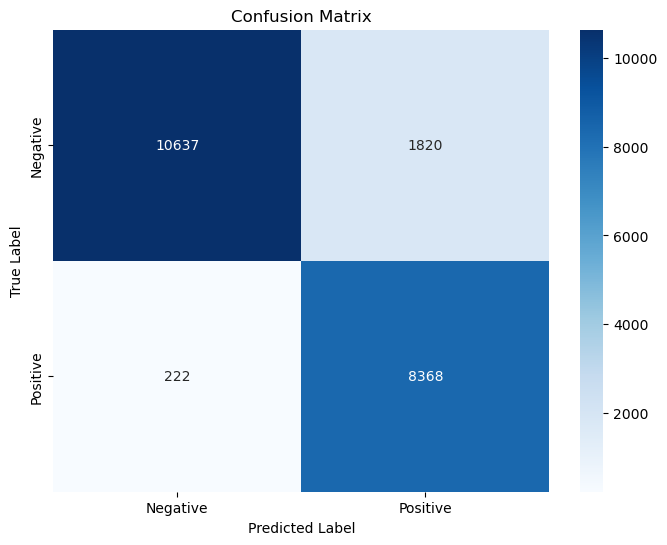

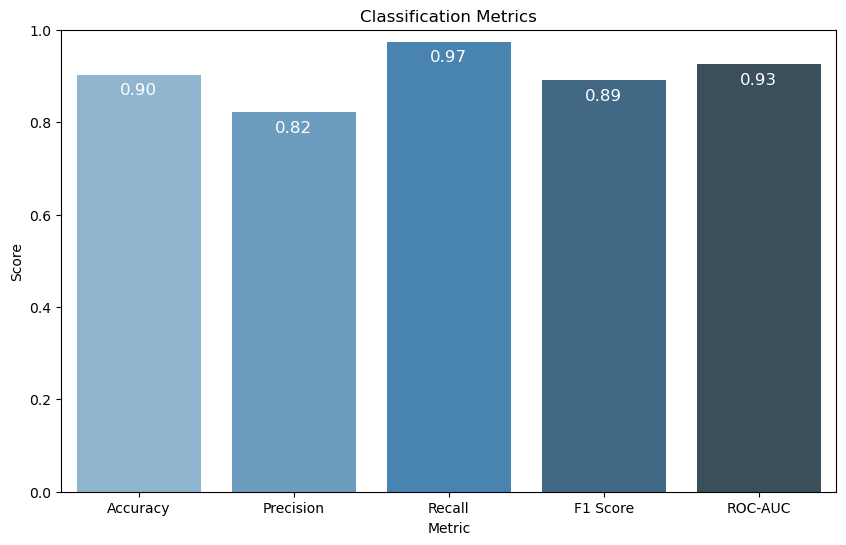

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def visualize_clf_eval_with_values(y_test, pred, pred_proba):
    # 성능 지표 계산
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)

    # 오차 행렬 출력
    print('오차 행렬:')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}'
          .format(accuracy, precision, recall, f1, roc_auc))

    # 1. 오차 행렬 시각화
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # 2. 성능 지표 시각화
    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC-AUC': roc_auc
    }

    plt.figure(figsize=(10, 6))
    bars = sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette='Blues_d')
    plt.ylim(0, 1)
    plt.title('Classification Metrics')
    plt.ylabel('Score')
    plt.xlabel('Metric')

    # 각 바에 숫자 표시 (소수점 2자리)
    for bar, value in zip(bars.patches, metrics.values()):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.05,
                 f'{value:.2f}', ha='center', va='bottom', color='white', fontsize=12)

    plt.show()

# Example usage (replace y_test, preds, pred_proba with your data)
visualize_clf_eval_with_values(y_test, preds, pred_proba)

오차 행렬:
[[10637  1820]
 [  222  8368]]
정확도: 0.9030, 정밀도: 0.8214, 재현율: 0.9742, F1: 0.8913, AUC: 0.9253


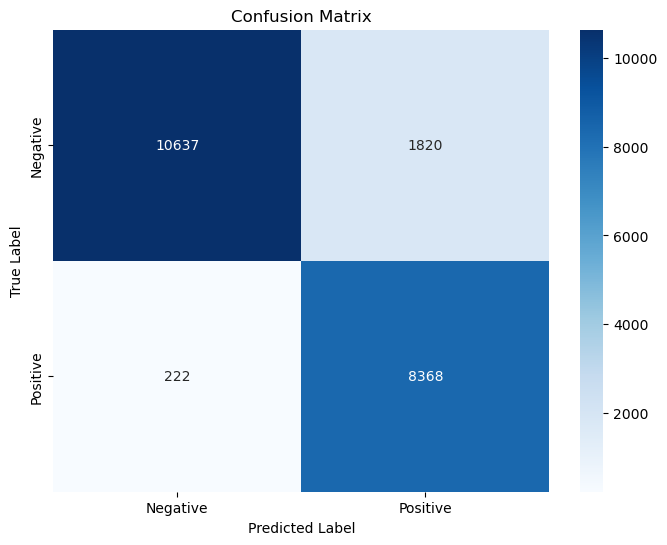

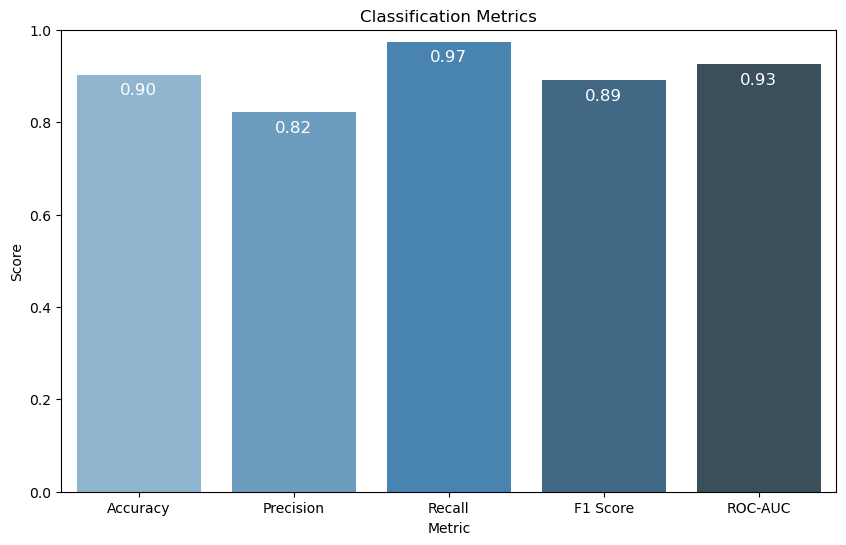

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def visualize_clf_eval_with_values(y_test, pred, pred_proba):
    # 성능 지표 계산
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)

    # 오차 행렬 출력
    print('오차 행렬:')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}'
          .format(accuracy, precision, recall, f1, roc_auc))

    # 1. 오차 행렬 시각화
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # 2. 성능 지표 시각화
    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC-AUC': roc_auc
    }

    plt.figure(figsize=(10, 6))
    bars = sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette='Blues_d')
    plt.ylim(0, 1)
    plt.title('Classification Metrics')
    plt.ylabel('Score')
    plt.xlabel('Metric')

    # 각 바에 숫자 표시 (소수점 2자리)
    for bar, value in zip(bars.patches, metrics.values()):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.05,
                 f'{value:.2f}', ha='center', va='bottom', color='white', fontsize=12)

    plt.show()

# Example usage (replace y_test, preds, pred_proba with your data)
visualize_clf_eval_with_values(y_test, preds, pred_proba)

In [ ]:
# LightGBM의 파이썬 패키지인 lightgbm에서 LGBMClassifier 임포트
from lightgbm import LGBMClassifier

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=156 )

from imblearn.over_sampling import SMOTE

# SMOTE를 사용한 오버샘플링
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 위에서 만든 X_train, y_train을 다시 쪼개서 90%는 학습과 10%는 검증용 데이터로 분리
X_tr, X_val, y_tr, y_val= train_test_split(X_train, y_train, test_size=0.1, random_state=156 )

# 앞서 XGBoost와 동일하게 n_estimators는 400 설정.
lgbm_wrapper = LGBMClassifier(n_estimators=400, learning_rate=0.05)

# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능.
evals = [(X_tr, y_tr), (X_val, y_val)]
lgbm_wrapper.fit(X_tr, y_tr, early_stopping_rounds=100, eval_metric="logloss", eval_set=evals, verbose=True)
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:, 1]

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	training's binary_logloss: 0.643741	valid_1's binary_logloss: 0.643048
[2]	training's binary_logloss: 0.613323	valid_1's binary_logloss: 0.612637
[3]	training's binary_logloss: 0.585721	valid_1's binary_logloss: 0.585037
[4]	training's binary_logloss: 0.560584	valid_1's binary_logloss: 0.559928
[5]	training's binary_logloss: 0.537618	valid_1's binary_logloss: 0.536994
[6]	training's binary_logloss: 0.516582	valid_1's binary_logloss: 0.515941
[7]	training's binary_logloss: 0.497263	valid_1's binary_logloss: 0.496613
[8]	training's binary_logloss: 0.479486	valid_1's binary_logloss: 0.478874
[9]	training's binary_logloss: 0.4631	valid_1's binary_logloss: 0.462486
[10]	training's binary_logloss: 0.44797	valid_1's binary_logloss: 0.447388
[11]	training's binary_logloss: 0.433984	valid_1's binary_logloss: 0.433398
[12]	training's binary_logloss: 0.421033	valid_1's binary_logloss: 0.420436
[13]	training's binary_logloss: 0.409021	valid_1's binary_logloss: 0.408442
[14]	training's binary_l

[113]	training's binary_logloss: 0.227122	valid_1's binary_logloss: 0.234
[114]	training's binary_logloss: 0.226968	valid_1's binary_logloss: 0.233952
[115]	training's binary_logloss: 0.226832	valid_1's binary_logloss: 0.233951
[116]	training's binary_logloss: 0.226674	valid_1's binary_logloss: 0.233904
[117]	training's binary_logloss: 0.226553	valid_1's binary_logloss: 0.233889
[118]	training's binary_logloss: 0.226426	valid_1's binary_logloss: 0.233951
[119]	training's binary_logloss: 0.226337	valid_1's binary_logloss: 0.233915
[120]	training's binary_logloss: 0.226215	valid_1's binary_logloss: 0.233893
[121]	training's binary_logloss: 0.226109	valid_1's binary_logloss: 0.233885
[122]	training's binary_logloss: 0.225986	valid_1's binary_logloss: 0.233856
[123]	training's binary_logloss: 0.225859	valid_1's binary_logloss: 0.23383
[124]	training's binary_logloss: 0.225756	valid_1's binary_logloss: 0.233825
[125]	training's binary_logloss: 0.225646	valid_1's binary_logloss: 0.233859
[12

[248]	training's binary_logloss: 0.214911	valid_1's binary_logloss: 0.233427
[249]	training's binary_logloss: 0.214855	valid_1's binary_logloss: 0.233418
[250]	training's binary_logloss: 0.214766	valid_1's binary_logloss: 0.233444
[251]	training's binary_logloss: 0.214671	valid_1's binary_logloss: 0.233437
[252]	training's binary_logloss: 0.214572	valid_1's binary_logloss: 0.233457
[253]	training's binary_logloss: 0.214504	valid_1's binary_logloss: 0.233472
[254]	training's binary_logloss: 0.214425	valid_1's binary_logloss: 0.23345
[255]	training's binary_logloss: 0.214337	valid_1's binary_logloss: 0.233436
[256]	training's binary_logloss: 0.214272	valid_1's binary_logloss: 0.233425
[257]	training's binary_logloss: 0.214227	valid_1's binary_logloss: 0.233424
[258]	training's binary_logloss: 0.214156	valid_1's binary_logloss: 0.233397
[259]	training's binary_logloss: 0.214062	valid_1's binary_logloss: 0.2334
[260]	training's binary_logloss: 0.213988	valid_1's binary_logloss: 0.233405
[2

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[10647  1810]
 [  224  8366]]
정확도: 0.9034, 정밀도: 0.8221, 재현율: 0.9739,    F1: 0.8916, AUC:0.9491


오차 행렬:
[[10647  1810]
 [  224  8366]]
정확도: 0.9034, 정밀도: 0.8221, 재현율: 0.9739, F1: 0.8916, AUC: 0.9491


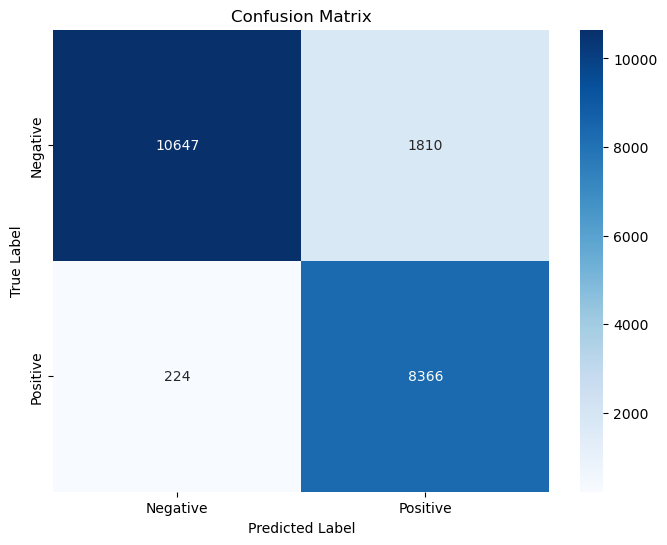

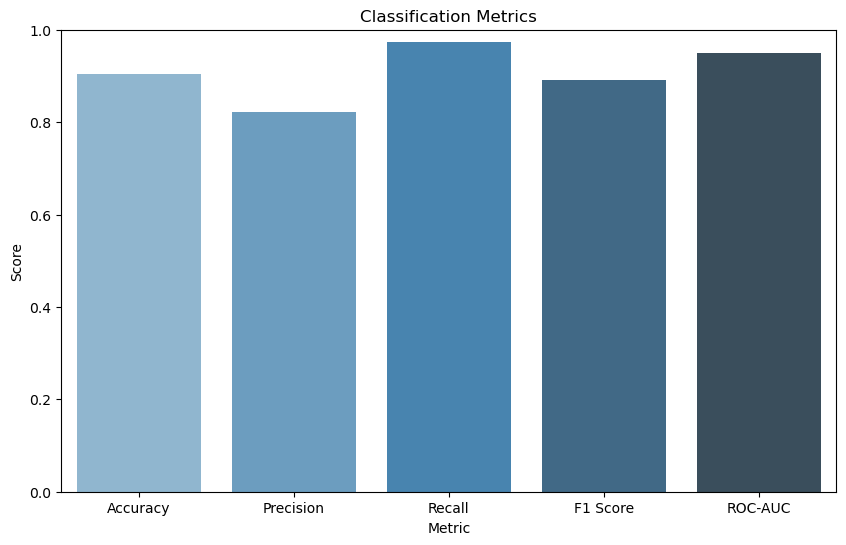

In [ ]:
def visualize_clf_eval(y_test, pred, pred_proba):
    # 성능 지표 계산
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)

    # 오차 행렬 출력
    print('오차 행렬:')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}'
          .format(accuracy, precision, recall, f1, roc_auc))

    # 1. 오차 행렬 시각화
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # 2. 성능 지표 시각화
    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC-AUC': roc_auc
    }

    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette='Blues_d')
    plt.ylim(0, 1)
    plt.title('Classification Metrics')
    plt.ylabel('Score')
    plt.xlabel('Metric')
    plt.show()

# Example usage (replace y_test, preds, pred_proba with your data)
visualize_clf_eval(y_test, preds, pred_proba)

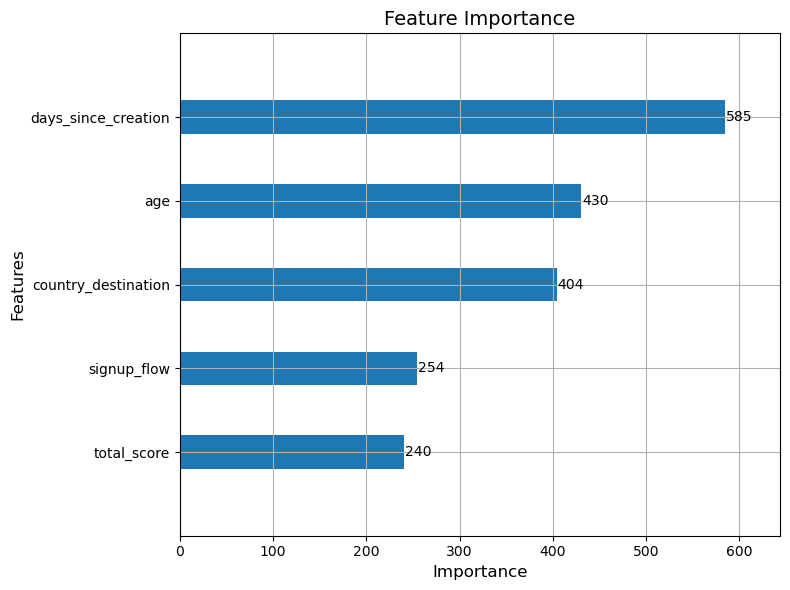

In [ ]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt

# 그래프 설정
fig, ax = plt.subplots(figsize=(8, 6))  # 더 작은 크기로 조정
plot_importance(lgbm_wrapper, ax=ax, max_num_features=5, height=0.4)  # height로 바 간격 조정
plt.title("Feature Importance", fontsize=14)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.tight_layout()  # 레이아웃 정리
plt.savefig('lightgbm_feature_importance.tif', format='tif', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import numpy as np

In [ ]:
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import numpy as np

# SMOTE를 사용한 오버샘플링
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 학습 데이터를 다시 90%:10%로 분리 (Train/Validation)
X_tr, X_val, y_tr, y_val = train_test_split(X_train_resampled, y_train_resampled, test_size=0.1, random_state=156)

# 하이퍼파라미터 탐색 공간
space = {
    'num_leaves': hp.choice('num_leaves', np.arange(20, 150, 10, dtype=int)),    # 20 ~ 150
    'max_depth': hp.choice('max_depth', np.arange(3, 20, dtype=int)),           # 3 ~ 20
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),                   # 0.01 ~ 0.3
    'min_child_weight': hp.uniform('min_child_weight', 1, 10),                 # 1 ~ 10
    'subsample': hp.uniform('subsample', 0.6, 1.0),                            # 0.6 ~ 1.0
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),              # 0.6 ~ 1.0
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),                                # 0 ~ 1
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),                              # 0 ~ 1
    'n_estimators': hp.choice('n_estimators', np.arange(100, 500, 50, dtype=int)) # 100 ~ 500
}

def objective(params):
    # LightGBM 모델 초기화
    model = LGBMClassifier(**params, random_state=42)

    # 모델 학습
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        eval_metric="logloss",
        early_stopping_rounds=50,
        verbose=False
    )

    # 검증 데이터로 예측
    pred_proba = model.predict_proba(X_val)[:, 1]

    # ROC-AUC 계산
    auc = roc_auc_score(y_val, pred_proba)

    # Hyperopt는 최소화를 목표로 하므로 -AUC 반환
    return {'loss': -auc, 'status': STATUS_OK}

In [ ]:
def objective(params):
    # LightGBM 모델 초기화
    model = LGBMClassifier(**params, random_state=42)

    # 모델 학습
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        eval_metric="logloss",
        early_stopping_rounds=50,
        verbose=False
    )

    # 검증 데이터로 예측
    pred_proba = model.predict_proba(X_val)[:, 1]

    # ROC-AUC 계산
    auc = roc_auc_score(y_val, pred_proba)

    # Hyperopt는 최소화를 목표로 하므로 -AUC 반환
    return {'loss': -auc, 'status': STATUS_OK}

In [ ]:
from hyperopt import Trials

# Trials 객체 생성 (최적화 과정 기록)
trials = Trials()

# Hyperopt 최적화 실행
best_params = fmin(
    fn=objective,         # 목적 함수
    space=space,          # 탐색 공간
    algo=tpe.suggest,     # TPE 알고리즘 사용
    max_evals=50,         # 최대 반복 횟수
    trials=trials,        # 결과 저장
    rstate=np.random.default_rng(42)  # 재현성을 위한 random state
)

print("최적의 하이퍼파라미터:", best_params)

  0%|                                                                           | 0/50 [00:00<?, ?trial/s, best loss=?]

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



  2%|▉                                                | 1/50 [00:02<02:22,  2.91s/trial, best loss: -0.957293076032641]

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



  4%|█▉                                               | 2/50 [00:05<02:18,  2.88s/trial, best loss: -0.957293076032641]

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



  6%|██▉                                              | 3/50 [00:08<02:06,  2.69s/trial, best loss: -0.957293076032641]

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



  8%|███▊                                            | 4/50 [00:12<02:33,  3.34s/trial, best loss: -0.9580801495912037]

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 10%|████▊                                           | 5/50 [00:15<02:24,  3.21s/trial, best loss: -0.9580801495912037]

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 12%|█████▊                                          | 6/50 [00:19<02:27,  3.36s/trial, best loss: -0.9580801495912037]

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 14%|██████▋                                         | 7/50 [00:22<02:19,  3.25s/trial, best loss: -0.9580801495912037]

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 16%|███████▋                                        | 8/50 [00:24<02:07,  3.03s/trial, best loss: -0.9580801495912037]

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 18%|████████▋                                       | 9/50 [00:27<02:03,  3.02s/trial, best loss: -0.9580801495912037]

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 20%|█████████▍                                     | 10/50 [00:31<02:11,  3.29s/trial, best loss: -0.9580801495912037]

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 22%|██████████▎                                    | 11/50 [00:34<01:57,  3.02s/trial, best loss: -0.9580801495912037]

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 24%|███████████▎                                   | 12/50 [00:36<01:45,  2.77s/trial, best loss: -0.9580801495912037]

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 26%|████████████▏                                  | 13/50 [00:38<01:35,  2.59s/trial, best loss: -0.9580801495912037]

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 28%|█████████████▏                                 | 14/50 [00:40<01:27,  2.42s/trial, best loss: -0.9580801495912037]

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 30%|██████████████                                 | 15/50 [00:43<01:31,  2.63s/trial, best loss: -0.9580801495912037]

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 32%|███████████████                                | 16/50 [00:45<01:24,  2.49s/trial, best loss: -0.9580801495912037]

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 34%|███████████████▉                               | 17/50 [00:50<01:46,  3.23s/trial, best loss: -0.9580801495912037]

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 36%|████████████████▉                              | 18/50 [00:54<01:46,  3.34s/trial, best loss: -0.9580801495912037]

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 38%|█████████████████▊                             | 19/50 [00:56<01:28,  2.87s/trial, best loss: -0.9580801495912037]

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 40%|██████████████████▊                            | 20/50 [00:59<01:26,  2.90s/trial, best loss: -0.9580801495912037]

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 42%|███████████████████▋                           | 21/50 [01:01<01:16,  2.64s/trial, best loss: -0.9580801495912037]

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 44%|████████████████████▋                          | 22/50 [01:03<01:09,  2.47s/trial, best loss: -0.9580801495912037]

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 46%|█████████████████████▌                         | 23/50 [01:06<01:11,  2.66s/trial, best loss: -0.9580801495912037]

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 48%|██████████████████████▌                        | 24/50 [01:10<01:22,  3.19s/trial, best loss: -0.9580801495912037]

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 50%|███████████████████████▌                       | 25/50 [01:11<01:04,  2.59s/trial, best loss: -0.9580801495912037]

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 52%|████████████████████████▍                      | 26/50 [01:13<00:58,  2.42s/trial, best loss: -0.9580801495912037]

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 54%|█████████████████████████▍                     | 27/50 [01:17<01:04,  2.82s/trial, best loss: -0.9580801495912037]

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 56%|██████████████████████████▎                    | 28/50 [01:19<00:54,  2.47s/trial, best loss: -0.9580801495912037]

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 58%|███████████████████████████▎                   | 29/50 [01:22<00:58,  2.80s/trial, best loss: -0.9580801495912037]

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 60%|████████████████████████████▏                  | 30/50 [01:24<00:51,  2.56s/trial, best loss: -0.9580801495912037]

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 62%|█████████████████████████████▏                 | 31/50 [01:28<00:52,  2.75s/trial, best loss: -0.9580801495912037]

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 64%|██████████████████████████████                 | 32/50 [01:30<00:49,  2.75s/trial, best loss: -0.9580801495912037]

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 66%|███████████████████████████████                | 33/50 [01:32<00:43,  2.53s/trial, best loss: -0.9580801495912037]

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 68%|███████████████████████████████▉               | 34/50 [01:35<00:40,  2.50s/trial, best loss: -0.9580801495912037]

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 70%|████████████████████████████████▉              | 35/50 [01:37<00:36,  2.44s/trial, best loss: -0.9580801495912037]

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 72%|█████████████████████████████████▊             | 36/50 [01:40<00:36,  2.62s/trial, best loss: -0.9580801495912037]

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 74%|██████████████████████████████████▊            | 37/50 [01:44<00:38,  2.98s/trial, best loss: -0.9580801495912037]

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 76%|███████████████████████████████████▋           | 38/50 [01:47<00:35,  2.97s/trial, best loss: -0.9580801495912037]

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 78%|████████████████████████████████████▋          | 39/50 [01:49<00:30,  2.79s/trial, best loss: -0.9580801495912037]

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 80%|█████████████████████████████████████▌         | 40/50 [01:52<00:28,  2.80s/trial, best loss: -0.9580801495912037]

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 82%|██████████████████████████████████████▌        | 41/50 [01:53<00:21,  2.36s/trial, best loss: -0.9580801495912037]

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 84%|███████████████████████████████████████▍       | 42/50 [01:56<00:20,  2.52s/trial, best loss: -0.9580801495912037]

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 86%|████████████████████████████████████████▍      | 43/50 [01:59<00:18,  2.62s/trial, best loss: -0.9580801495912037]

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 88%|█████████████████████████████████████████▎     | 44/50 [02:01<00:14,  2.37s/trial, best loss: -0.9580801495912037]

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 90%|██████████████████████████████████████████▎    | 45/50 [02:05<00:13,  2.74s/trial, best loss: -0.9580801495912037]

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 92%|███████████████████████████████████████████▏   | 46/50 [02:10<00:13,  3.48s/trial, best loss: -0.9580801495912037]

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 94%|████████████████████████████████████████████▏  | 47/50 [02:12<00:09,  3.19s/trial, best loss: -0.9580801495912037]

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 96%|█████████████████████████████████████████████  | 48/50 [02:14<00:05,  2.86s/trial, best loss: -0.9580801495912037]

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 98%|██████████████████████████████████████████████ | 49/50 [02:18<00:02,  3.00s/trial, best loss: -0.9580801495912037]

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\82104\anaconda3\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



100%|███████████████████████████████████████████████| 50/50 [02:20<00:00,  2.81s/trial, best loss: -0.9580801495912037]
최적의 하이퍼파라미터: {'colsample_bytree': 0.8334126409787352, 'learning_rate': 0.06972293866675108, 'max_depth': 16, 'min_child_weight': 1.6652489079296724, 'n_estimators': 5, 'num_leaves': 3, 'reg_alpha': 0.5924534133258075, 'reg_lambda': 0.21221711699333523, 'subsample': 0.7615110681047916}


In [ ]:
# 최적의 하이퍼파라미터 변환
optimized_params = {
    'num_leaves': np.arange(20, 150, 10)[best_params['num_leaves']],
    'max_depth': np.arange(3, 20)[best_params['max_depth']],
    'learning_rate': best_params['learning_rate'],
    'min_child_weight': best_params['min_child_weight'],
    'subsample': best_params['subsample'],
    'colsample_bytree': best_params['colsample_bytree'],
    'reg_alpha': best_params['reg_alpha'],
    'reg_lambda': best_params['reg_lambda'],
    'n_estimators': np.arange(100, 500, 50)[best_params['n_estimators']]
}

# 최적의 파라미터로 모델 학습
final_model = LGBMClassifier(**optimized_params, random_state=42)
final_model.fit(X_train_resampled, y_train_resampled)

# 테스트 데이터 평가
test_preds = final_model.predict(X_test)
test_pred_proba = final_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, test_pred_proba)
print("최종 테스트 데이터 ROC-AUC:", test_auc)

최종 테스트 데이터 ROC-AUC: 0.948005343270256


In [ ]:
get_clf_eval(y_test, test_preds, test_pred_proba)

오차 행렬
[[10653  1804]
 [  230  8360]]
정확도: 0.9034, 정밀도: 0.8225, 재현율: 0.9732,    F1: 0.8915, AUC:0.9480


오차 행렬:
[[10647  1810]
 [  224  8366]]
정확도: 0.9034, 정밀도: 0.8221, 재현율: 0.9739, F1: 0.8916, AUC: 0.9491


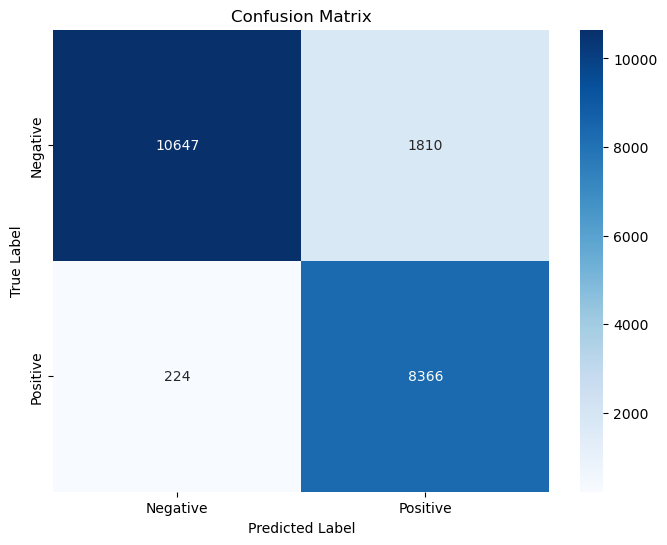

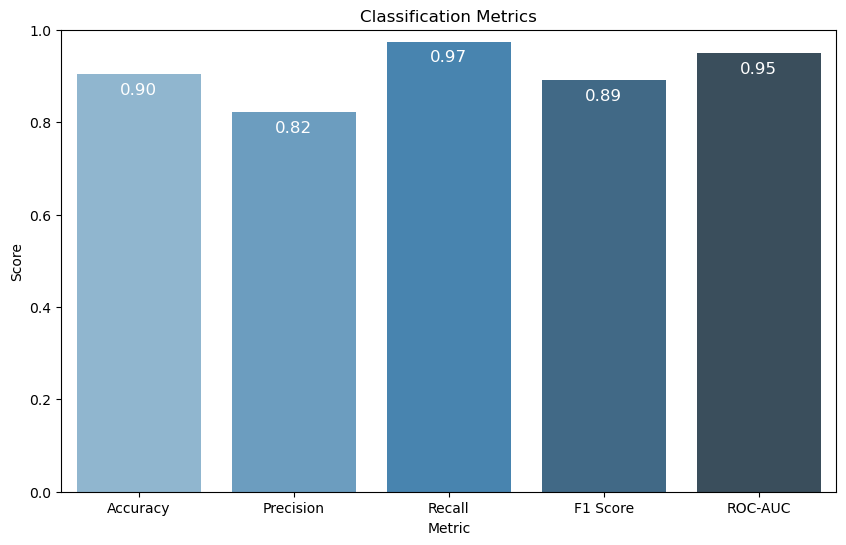

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def visualize_clf_eval_with_values(y_test, pred, pred_proba):
    # 성능 지표 계산
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)

    # 오차 행렬 출력
    print('오차 행렬:')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}'
          .format(accuracy, precision, recall, f1, roc_auc))

    # 1. 오차 행렬 시각화
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # 2. 성능 지표 시각화
    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC-AUC': roc_auc
    }

    plt.figure(figsize=(10, 6))
    bars = sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette='Blues_d')
    plt.ylim(0, 1)
    plt.title('Classification Metrics')
    plt.ylabel('Score')
    plt.xlabel('Metric')

    # 각 바에 숫자 표시 (소수점 2자리)
    for bar, value in zip(bars.patches, metrics.values()):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.05,
                 f'{value:.2f}', ha='center', va='bottom', color='white', fontsize=12)

    plt.show()

# Example usage (replace y_test, preds, pred_proba with your data)
visualize_clf_eval_with_values(y_test, preds, pred_proba)